In [ ]:
!nvidia-smi


Mon Dec  9 16:01:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

![image-2.png](attachment:image-2.png)

## This final project focuses on leveraging the techniques and concepts you've learned throughout this course.
- You will apply image processing, feature extraction, and pattern recognition methods to solve real-world challenges. Specifically, you will implement and fine-tune state-of-the-art algorithms like Convolutional Neural Networks (CNNs), object detection, image segmentation, or feature matching.

we'll build a CNN using Keras to use it classifying thousands of pictures in six different categories

Data link : https://www.kaggle.com/puneet6060/intel-image-classification

#Import Libraries

In [ ]:
pip install tensorflow


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob as gb
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from tqdm import tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob as gb
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from tqdm import tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support

#define the path ( to swtich it between jupyter notebook & kaggle kernel)

In [ ]:
os.getcwd()
train_path = r'/content/drive/My Drive/Colab Notebooks/computer vision projects/Machine Learning Drive/CNN_Proj/seg_train'
test_path = r'/content/drive/My Drive/Colab Notebooks/computer vision projects/Machine Learning Drive/CNN_Proj/seg_test'
pred_path = r'/content/drive/My Drive/Colab Notebooks/computer vision projects/Machine Learning Drive/CNN_Proj/seg_pred'

# Open Folders

now let's first check the Train folder to have a look to its content

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/computer vision projects')

In [ ]:
from my_functions import count_images_in_folders

In [ ]:
# Count images in training, testing, and prediction data
count_images_in_folders(train_path, 'training')
count_images_in_folders(test_path, 'testing')
count_images_in_folders(pred_path, 'prediction',is_subfolder= False )

For training data, found 2404 images in folder "glacier".
For training data, found 2271 images in folder "forest".
For training data, found 2191 images in folder "buildings".
For training data, found 2512 images in folder "mountain".
For training data, found 2274 images in folder "sea".
For training data, found 2382 images in folder "street".
For testing data, found 553 images in folder "glacier".
For testing data, found 474 images in folder "forest".
For testing data, found 437 images in folder "buildings".
For testing data, found 525 images in folder "mountain".
For testing data, found 510 images in folder "sea".
For testing data, found 501 images in folder "street".
For prediction data, found 7301 images in the folder 


#Checking Images
now we need to heck the images sizes , to know ow they looks like

since we have 6 categories , we first need to create a dictionary with their names & indices , also create a function to get the code back

In [ ]:
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}
def get_code(n):
    for x,y in code.items():
        if n==y:
            return x
get_code(5)

'street'

In [ ]:
from my_functions import get_image_sizes

In [ ]:
# Usage examples
train_sizes = get_image_sizes(train_path, is_subfolder=True)
test_sizes = get_image_sizes(test_path, is_subfolder=True)
pred_sizes = get_image_sizes(pred_path, is_subfolder=False)

print("Train Image Sizes:\n", train_sizes)
print("Test Image Sizes:\n", test_sizes)
print("Prediction Image Sizes:\n", pred_sizes)

ok , since almost all of pictures are 150,150,3 , we can feel comfort in using all pictures in our model , after resizing it in a specific amount

#Reading Images
now it's time to read all images & convert it into arrays

first we'll create a variable s , which refer to size , so we can change it easily

let's use now size = 100 , so it will be suitable amount to contain accuracy without losing so much time in training

In [ ]:
from my_functions import load_images

In [ ]:
# Usage for train data
x_train, y_train = load_images(train_path, code, resize_shape=(100,100),div_num=10 ,is_subfolder=True)

# Usage for test data
x_test, y_test = load_images(test_path, code, resize_shape=(100,100),div_num=20, is_subfolder=True)

# Usage for prediction data (no labels)
x_pred, _ = load_images(pred_path,code=None, resize_shape=(100,100),div_num=20, is_subfolder=False)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
print(f"x_pred shape: {x_pred.shape}")

x_train shape: (1408, 100, 100, 3), y_train shape: (1408,)
x_test shape: (153, 100, 100, 3), y_test shape: (153,)
x_pred shape: (366, 100, 100, 3)


In [ ]:
print(type(x_train))

<class 'numpy.ndarray'>


In [ ]:
#implement same as vgg16
KerasModel = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(200, activation='relu', kernel_size=(3,3),padding='same', input_shape=(100,100,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(180, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(160, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Conv2D(100, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(60, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Conv2D(140, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(120, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Conv2D(100, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(50, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(40, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(40, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(30, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dropout(rate=0.8),
    tf.keras.layers.Dense(6, activation='softmax')
])
KerasModel.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 200)       │           5,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 100, 200)       │             800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 180)       │         324,180 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100, 100, 180)       │             720 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 100, 100, 160)       │         259,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100, 100, 160)       │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 160)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 50, 50, 100)         │         144,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 50, 50, 100)         │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 50, 50, 60)          │          54,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 50, 50, 60)          │             240 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 60)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 25, 25, 140)         │          75,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 25, 25, 140)         │             560 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 25, 25, 120)         │         151,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 25, 25, 120)         │             480 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 120)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 100)         │         108,1

 Total params: 3,583,758 (13.67 MB)

 Trainable params: 3,581,318 (13.66 MB)

 Non-trainable params: 2,440 (9.53 KB)

In [ ]:
KerasModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:

# Define the path where you want to save the best model
model_save_path = 'C:\mahmoud\My Work\Gasco\Machine learning and AI\computer vision\Project/best_model.keras'  # Specify your desired path and filename

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    model_save_path,
    monitor='val_loss',  # Monitor validation loss; change to 'val_accuracy' if desired
    save_best_only=True,  # Save only the best model
    mode='min',  # 'min' for loss, 'max' for accuracy
    verbose=1  # Verbosity mode, 1 = save messages
)

# Train the model with the ModelCheckpoint callback
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)
model = KerasModel.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),  # Make sure to include validation data
    epochs=16,
    batch_size=64,
    verbose=1,
    callbacks=[checkpoint,lr_scheduler]  # Pass the checkpoint callback here
)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.8302 - loss: 0.4905
Epoch 1: val_loss improved from inf to 1.06760, saving model to C:\mahmoud\My Work\Gasco\Machine learning and AI\computer vision\Project/best_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 569ms/step - accuracy: 0.8300 - loss: 0.4903 - val_accuracy: 0.6209 - val_loss: 1.0676 - learning_rate: 5.0000e-04
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.8276 - loss: 0.4880
Epoch 2: val_loss did not improve from 1.06760
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 585ms/step - accuracy: 0.8277 - loss: 0.4871 - val_accuracy: 0.6209 - val_loss: 1.2291 - learning_rate: 5.0000e-04
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.8518 - loss: 0.3881
Epoch 3: val_loss did not improve from 1.06760
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 586ms/step - accuracy: 0.8515 - loss: 0.3891 - val_accuracy: 0.6340 - val_loss: 1.2120 - learning_rate: 5.0000e-04
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - ac

In [ ]:
loss,accuracy=KerasModel.evaluate(x_test,y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.7353 - loss: 1.3032


In [ ]:
print(f'loss is {loss}')
print(f'accuracy is {accuracy}')

loss is 1.2657808065414429
accuracy is 0.7189542651176453


In [ ]:
y_result = KerasModel.predict(x_pred)

y_result

12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 687ms/step


array([[3.6933417e-03, 2.1884231e-01, 4.3787673e-02, 8.1025512e-04,
        2.9939640e-04, 7.3256707e-01],
       [3.8613239e-03, 2.1173319e-05, 5.6657754e-09, 5.0794299e-08,
        4.3991992e-09, 9.9611747e-01],
       [5.5564007e-05, 8.2257543e-07, 2.7129604e-02, 1.8662694e-01,
        7.8618592e-01, 1.0796539e-06],
       ...,
       [1.0309495e-07, 2.6051794e-10, 1.5200020e-03, 1.0224327e-03,
        9.9745744e-01, 7.1599140e-09],
       [1.2087271e-01, 7.8036112e-04, 4.6605164e-01, 1.8614167e-01,
        2.1076615e-01, 1.5387333e-02],
       [2.5802676e-02, 5.3644865e-03, 3.2319447e-01, 1.2830898e-01,
        5.1474082e-01, 2.5885298e-03]], dtype=float32)

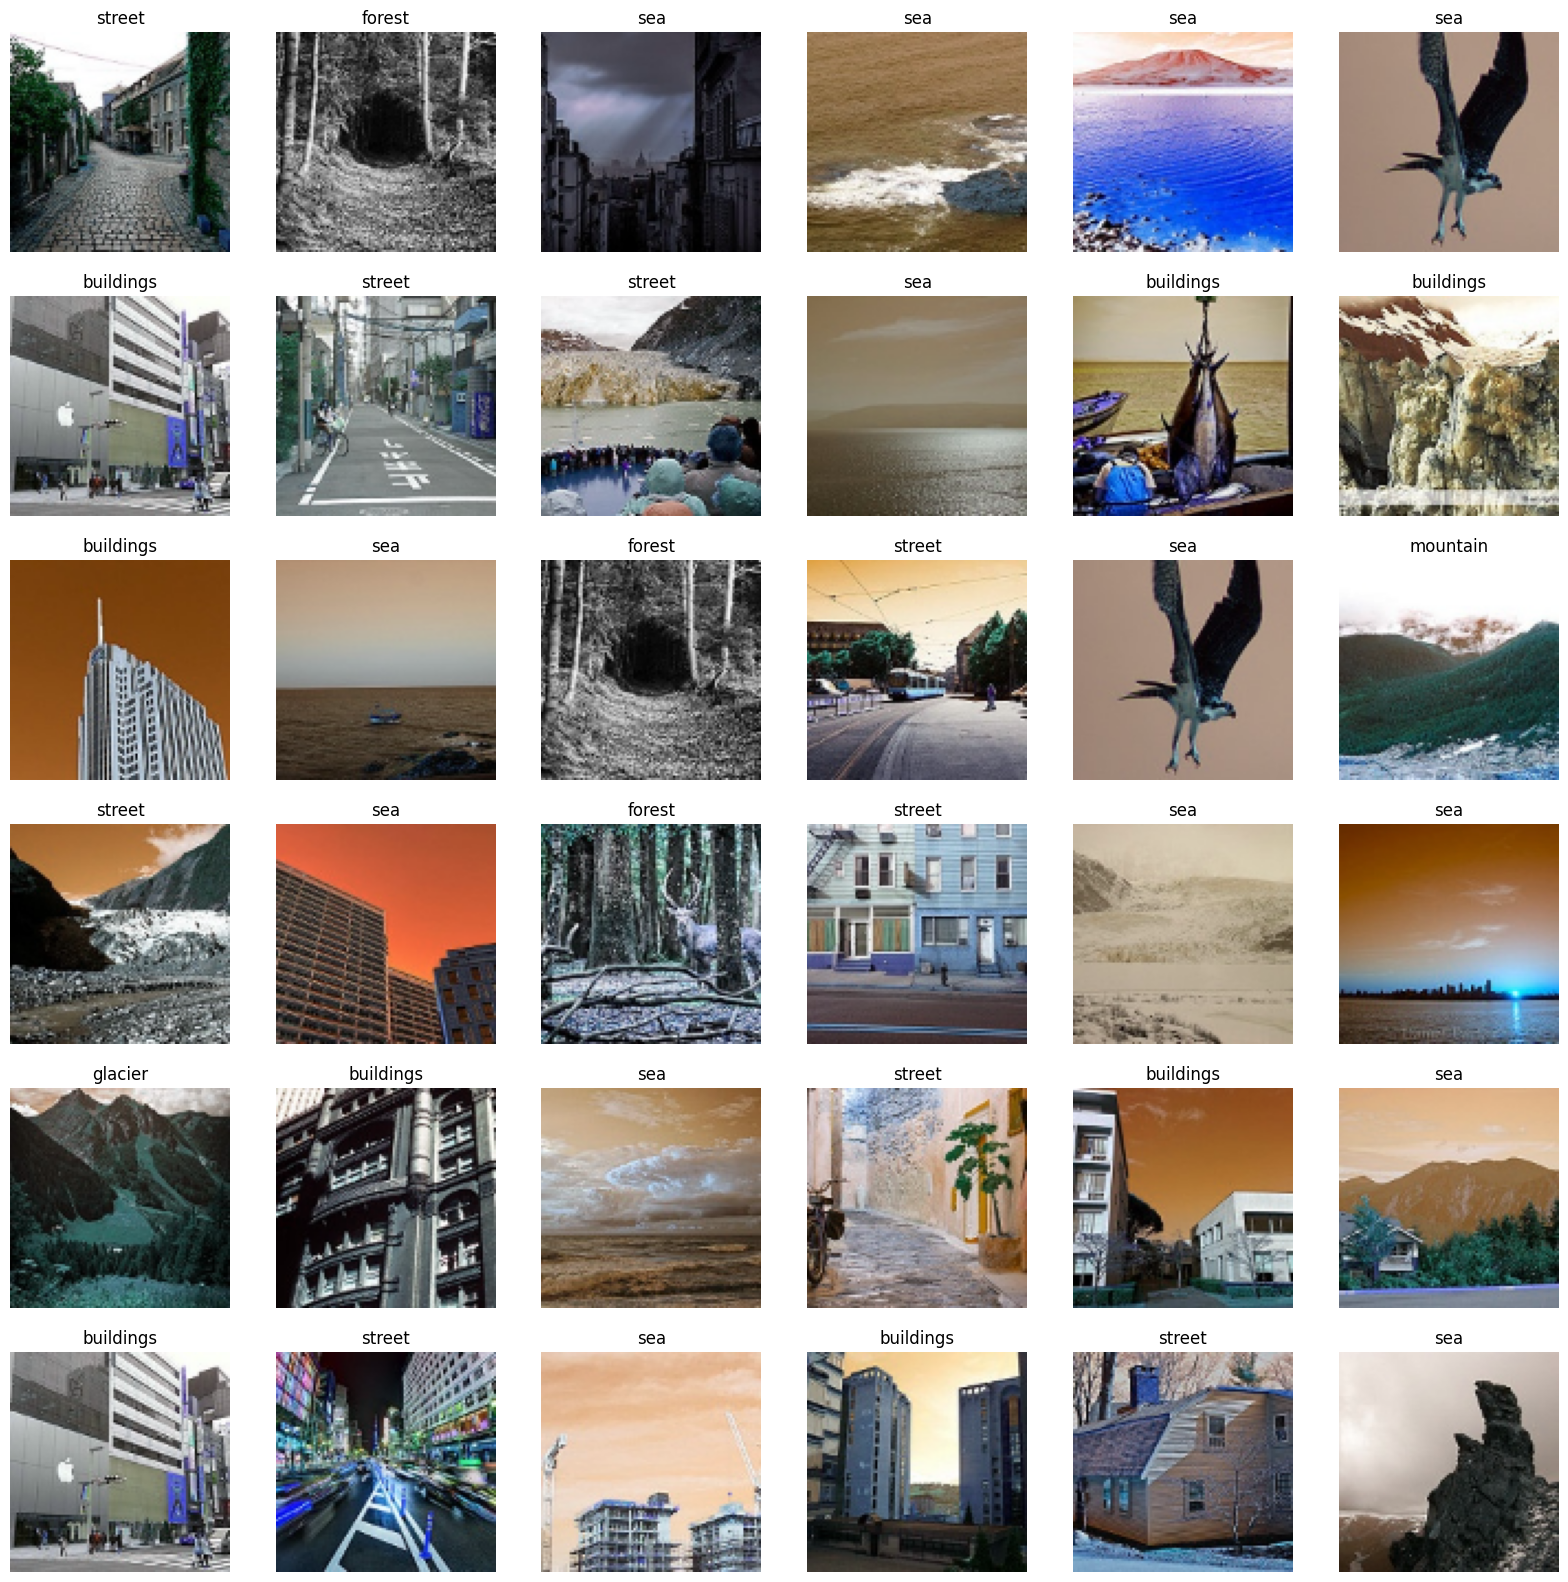

In [ ]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(x_pred),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(x_pred[i])
    plt.axis('off')
    plt.title(get_code(np.argmax(y_result[i])))

In [ ]:
y_pred = KerasModel.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

labels = list(code.values())
target_names = list(code.keys())
report = classification_report(y_test, y_pred_classes, labels=labels, target_names=target_names)

print(report)

from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_classes, labels=labels, target_names=target_names)

print(report)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_classes, labels=labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step
              precision    recall  f1-score   support

   buildings       0.68      0.77      0.72        22
      forest       0.95      0.79      0.86        24
     glacier       0.76      0.79      0.77        28
    mountain       0.57      0.59      0.58        27
         sea       0.65      0.58      0.61        26
      street       0.75      0.81      0.78        26

    accuracy                           0.72       153
   macro avg       0.73      0.72      0.72       153
weighted avg       0.72      0.72      0.72       153

              precision    recall  f1-score   support

   buildings       0.68      0.77      0.72        22
      forest       0.95      0.79      0.86        24
     glacier       0.76      0.79      0.77        28
    mountain       0.57      0.59      0.58        27
         sea       0.65      0.58      0.61        26
      street       0.75      0.81      0.78        26

    accuracy                          

## In the code above, I have provided you with a written code, but it contains errors. Each of you must trace the errors and improve the accuracy for each model, recording the changes in the table below. Then, answer the following questions.

| Network          | Accuracy | Recall | Precision | F1-Score |
|------------------|----------|--------|-----------|----------|
| Your CNN model   |          |        |           |          |
| VGG16            |          |        |           |          |
| VGG19            |          |        |           |          |
| Inception_V3     |          |        |           |          |
| RasNet152V2      |          |        |           |          |
| DenseNet         |          |        |           |          |


# Experimental Results